## Evolution Strategies: Atari

![img](https://t4.ftcdn.net/jpg/00/17/46/81/240_F_17468143_wY3hsHyfNYoMdG9BlC56HI4JA7pNu63h.jpg)

[The paper about the algorithm](https://arxiv.org/abs/1703.03864)

In this notebook you should train an agent for one of the simplest and popular Atari game: Pong!

In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [2]:
from matplotlib import pyplot as plt
from IPython.display import clear_output
from IPython import display
import torch
from torch import nn
import time
from copy import deepcopy
from joblib import Parallel, delayed


Bad key savefig.frameon in file /home/igormarkov00/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /home/igormarkov00/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /home/igormarkov00/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probably need t

### N-grams

A single grame of Atari doesn't contain all the necessary information about the environment state.
We deal with this problem by using 4-frame buffers instead of single frames as input. This is a common trick for so-called "partially observable" environments if you don't want to use RNNs. At first you are going to implement this small hack.

We help you a little bit by setting a good crop and resize so the image will be significantly smaller but the agent will still have all the information.

### Installation of atari:
You have to run `pip install --upgrade gym[atari]==0.19` on your local machine. If you have some problems with the installation, please ask your classmates or google the error message.

In [3]:
import numpy as np
import gym
from gym.core import Wrapper
from gym.spaces.box import Box
import cv2

def make_pong():
    """creates breakout env with all preprocessing done for you"""
    return PreprocessAtari(gym.make("PongDeterministic-v0"))


class PreprocessAtari(Wrapper):
    def __init__(self, env, height=42, width=42,
                 crop=lambda img: img[34:34 + 160], n_frames=4):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(PreprocessAtari, self).__init__(env)
        self.img_size = (height, width)
        self.crop = crop
        self.observation_space = Box(0.0, 1.0, [n_frames, height, width])
        self.framebuffer = np.zeros([n_frames, height, width])

    def reset(self):
        """resets breakout, returns initial frames"""
        img = self.env.reset()
        self.framebuffer = np.zeros(self.framebuffer.shape) + self.preproc_image(img)[None, :]
        return self.framebuffer

    def step(self, action):
        """plays breakout for 1 step, returns 4-frame buffer"""
        img, reward, done, info = self.env.step(action)
        self.update_buffer(img)
        return self.framebuffer, reward, done, info

    ###image processing###

    def update_buffer(self, img):
        self.framebuffer[1:] = self.framebuffer[0:-1]
        self.framebuffer[0] = self.preproc_image(img)

    def preproc_image(self, img):
        """what happens to the observation"""
        img = self.crop(img)
        img = cv2.resize(src=img,
                       dsize=self.img_size,
                       interpolation=cv2.INTER_CUBIC).mean(-1)
        img = img.astype('float32') / 255.
        return (img - img.mean()) / (img.std() + 1e-5)

In [4]:
env = make_pong()
print(env.action_space)

Discrete(6)


### The challenge
Feel free to use everything you did at the seminar. 

If you achieve average score -10, it's the success!

In [5]:
def display_session(env, agent, t_max=10000):
    total_reward = 0
    plt.figure(figsize=(8, 6))
    display.clear_output(wait=True)

    s = env.reset()
    
    for t in range(t_max):
        plt.gca().clear()
        
        a = agent.get_action(torch.tensor(s).float())
        new_s, r, done, info = env.step(a)
        s = new_s
        total_reward += r
        # Draw game image on display.
        plt.imshow(env.render('rgb_array'))

        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        if done:
            break
            
    return total_reward

In [7]:
def generate_session(env, agent, t_max=10000):
    total_reward = 0
    s = env.reset()
    
    for t in range(t_max):
        a = agent.get_action(torch.tensor(s).float())
        new_s, r, done, info = env.step(a)
        total_reward += r
        s = new_s
        
        if done:
            break
            
    return total_reward


def score(env, agent, n=10, t_max=10000):
    return np.mean([generate_session(env, agent, t_max) for _ in range(n)])

In [8]:
def add_noise_to_model(model, noise, copy=False):
    if copy:
        model = deepcopy(model)
    for parameter, p_noise in zip(model.parameters(), noise):
        parameter.data += torch.tensor(p_noise)
    return model

In [9]:
from tqdm import trange

class EvaluationManager:
    def __init__(self, get_env_function, lr=0.001, std=0.01, n_samples = 64, normalize=True, n_threads=1,
                 t_max=10000):
        super().__init__()
        
        self.lr = lr
        self.std = std
        self.normalize = normalize
        self.n_samples = n_samples
        self.mean_reward_history = []
        self.n_threads = n_threads
        self.env = get_env_function()
        self.t_max=t_max
        
    def get_noised_model(self, model):
        noise = [np.random.normal(scale=self.std, size=param.shape) for param in model.parameters()]
        return add_noise_to_model(model, noise, copy=True), noise

    def optimize(self, model, noises, rewards):
        total_noise = []
        for i, p in enumerate(model.parameters()):
            total_noise.append(np.zeros(p.shape))
            for noise, r in zip(noises, rewards):
                total_noise[-1] += r * noise[i] / (self.std**2) * self.lr / len(noises)
        add_noise_to_model(model, total_noise)
    
    def step(self, model):
        noises = []
        rewards = []
        noised_models = []
        for _ in range(self.n_samples):
            noised_model, noise = self.get_noised_model(model)
            noises.append(noise)
            noised_models.append(noised_model)
        
        if self.n_threads == 1:
            for i in trange(self.n_samples):
                rewards.append(score(self.env, noised_models[i], t_max=self.t_max))
        else:
            rewards = list(Parallel(n_jobs=self.n_threads)(delayed(score)(deepcopy(self.env), noised_models[i], t_max=self.t_max) for i in trange(self.n_samples)))
            
        normed_rewards = np.array(rewards)
        if self.normalize:
            normed_rewards = (normed_rewards - normed_rewards.mean()) / (normed_rewards.std() + 1e-3)

        self.optimize(model, noises, normed_rewards)
        self.update_log(rewards)
        
    def update_log(self, rewards):
        mean_reward = np.mean(rewards)
        self.mean_reward_history.append(mean_reward)

        clear_output(True)
        print("last mean reward = %.3f" % mean_reward)
        plt.figure(figsize=[8, 4])
        plt.subplot(1, 2, 1)
        plt.plot(self.mean_reward_history, label='Mean rewards')
        plt.legend()
        plt.grid()

        plt.subplot(1, 2, 2)
        plt.hist(rewards)
        plt.grid()

        plt.show()
    

In [18]:
class IgorConvPolicy(nn.Module):
    def __init__(self, state_size, actions, hid_size=64):
        super(IgorConvPolicy, self).__init__()
        self.actions = actions
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=state_size[0], out_channels=4, kernel_size=3, bias=False)
        )
        self.lin = nn.Sequential(
            nn.Linear(6400, len(actions), bias=False)
        )

    def get_action(self, state):
        conved_state = self.conv(state[None, :]).flatten()
        return self.actions[int(torch.argmax(self.lin(conved_state)).numpy())]

last mean reward = 0.755


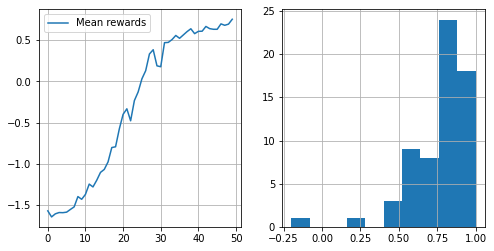

43.909974098205566


In [19]:
model_conv = IgorConvPolicy(env.observation_space.shape, [1, 2, 3])
algorithm = EvaluationManager(make_pong, lr=0.01, std=0.1, n_samples=64, normalize=True, n_threads=-1,
                              t_max=100)

for i in range(50):
    t = time.time()
    algorithm.step(model_conv)
    print(time.time() - t)

Total reward:  -20.0


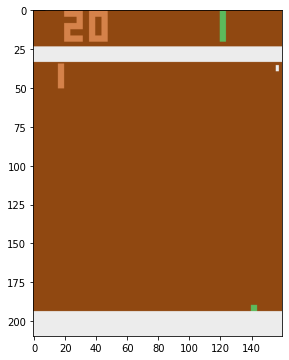

In [22]:
total_reward = display_session(env, model_conv)
print('Total reward: ', total_reward)

last mean reward = 0.062


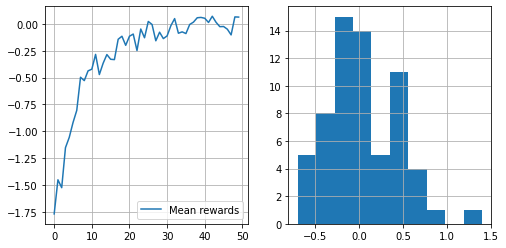

106.48103833198547


In [23]:
algorithm = EvaluationManager(make_pong, lr=0.01, std=0.1, n_samples=64, normalize=True, n_threads=-1,
                              t_max=300)

for i in range(50):
    t = time.time()
    algorithm.step(model_conv)
    print(time.time() - t)

Total reward:  -13.0


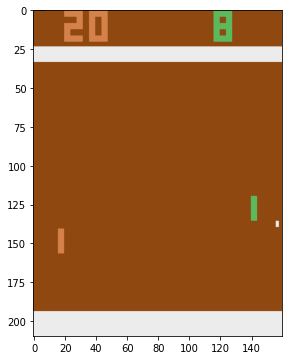

In [27]:
total_reward = display_session(env, model_conv)
print('Total reward: ', total_reward)

last mean reward = -0.844


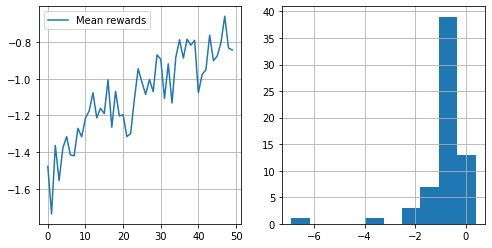

197.55685544013977


In [28]:
algorithm = EvaluationManager(make_pong, lr=0.01, std=0.1, n_samples=64, normalize=True, n_threads=-1,
                              t_max=600)

for i in range(50):
    t = time.time()
    algorithm.step(model_conv)
    print(time.time() - t)

Total reward:  -13.0


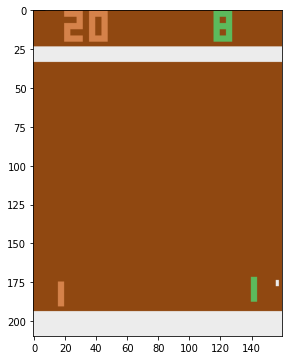

In [29]:
total_reward = display_session(env, model_conv)
print('Total reward: ', total_reward)

In [30]:
model1200 = deepcopy(model_conv)

last mean reward = 0.045


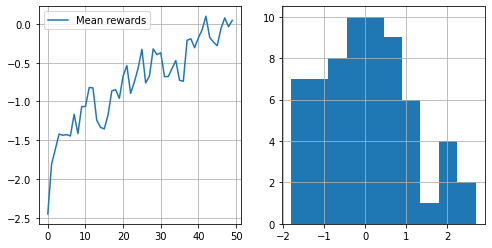

377.4688928127289


In [31]:
algorithm = EvaluationManager(make_pong, lr=0.01, std=0.05, n_samples=64, normalize=True, n_threads=-1,
                              t_max=1200)

for i in range(50):
    t = time.time()
    algorithm.step(model1200)
    print(time.time() - t)

Total reward:  2.0


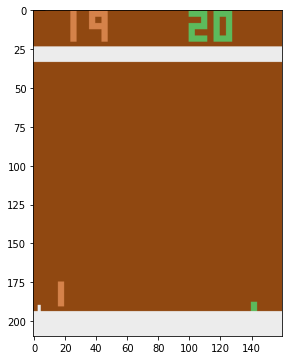

In [32]:
total_reward = display_session(env, model1200)
print('Total reward: ', total_reward)

In [37]:
score(make_pong(), model1200, n=30, t_max=100000)

-2.5

In [38]:
score(make_pong(), model1200, n=30, t_max=100000)

-1.5

In [35]:
model3000 = deepcopy(model1200)

last mean reward = -0.409


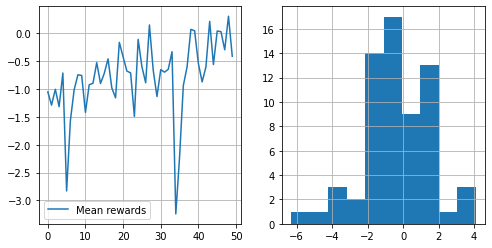

935.7702584266663


In [39]:
algorithm = EvaluationManager(make_pong, lr=0.01, std=0.05, n_samples=64, normalize=True, n_threads=-1,
                              t_max=3000)

for i in range(50):
    t = time.time()
    algorithm.step(model3000)
    print(time.time() - t)

Total reward:  11.0


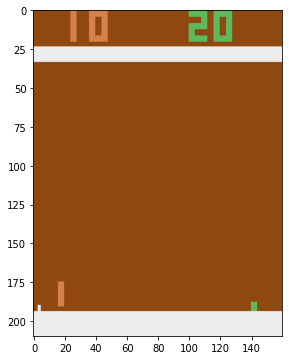

In [40]:
total_reward = display_session(env, model3000)
print('Total reward: ', total_reward)

In [43]:
score(make_pong(), model3000, n=30, t_max=100000)

1.0333333333333334

In [44]:
score(make_pong(), model3000, n=30, t_max=100000)

2.8

In [48]:
model10000 = deepcopy(model3000)

last mean reward = -0.150


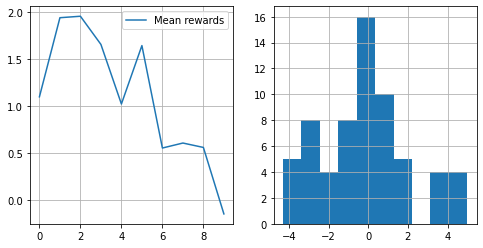

1551.4536890983582


In [49]:
algorithm = EvaluationManager(make_pong, lr=0.002, std=0.01, n_samples=64, normalize=True, n_threads=-1,
                              t_max=10000)

for i in range(10):
    t = time.time()
    algorithm.step(model10000)
    print(time.time() - t)

In [ ]:
total_reward = display_session(env, model10000)
print('Total reward: ', total_reward)

In [ ]:
score(make_pong(), model10000, n=30, t_max=100000)

In [51]:
torch.save(model3000, 'model3000')

In [77]:
class GreedyEvaluationManager(EvaluationManager):
    def __init__(self, get_env_function, lr=0.001, std=0.01, n_samples=64, normalize=True, n_threads=1,
                 t_max=10000):
        super(GreedyEvaluationManager, self).__init__(get_env_function, lr=lr, std=std, n_samples=n_samples,
                                                      normalize=normalize, n_threads=n_threads, t_max=t_max)

    def optimize(self, model, noises, rewards):
        add_noise_to_model(model, [self.lr * noise for noise in noises[int(np.argmax(rewards))]])


In [79]:
model_greedy = deepcopy(model3000)

last mean reward = 1.312


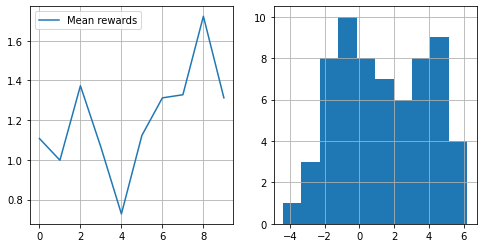

1354.9658885002136


In [80]:
algorithm = GreedyEvaluationManager(make_pong, lr=0.002, std=0.01, n_samples=64, normalize=True, n_threads=-1,
                                    t_max=10000)

for i in range(10):
    t = time.time()
    algorithm.step(model_greedy)
    print(time.time() - t)

In [91]:
score(make_pong(), model_greedy, n=30, t_max=100000)

-1.1

In [95]:
from tqdm import trange

class SuperGreedyEvaluationManager:
    def __init__(self, get_env_function, std=0.01, t_max=10000, n_iters=50):
        super().__init__()
        
        self.std = std
        self.mean_reward_history = []
        self.env = get_env_function()
        self.t_max = t_max
        self.n_iters = n_iters
        
    def get_noised_model(self, model):
        noise = [np.random.normal(scale=self.std, size=param.shape) for param in model.parameters()]
        return add_noise_to_model(model, noise, copy=True), noise
    
    def step(self, model):
        noised_model, _ = self.get_noised_model(model)
        old_score = np.mean([generate_session(env, model, self.t_max) for _ in trange(self.n_iters)])
        new_score = np.mean([generate_session(env, noised_model, self.t_max) for _ in trange(self.n_iters)])
        if new_score > old_score:
            model = noised_model
        self.update_log(old_score, new_score)

    def update_log(self, old_score, new_score):
        mean_reward = max(old_score, new_score)
        self.mean_reward_history.append(mean_reward)

        clear_output(True)
        print("last mean reward = %.3f" % mean_reward)
        print('Old Score = %.3f' % old_score)
        print('New Score = %.3f' % new_score)
        plt.figure(figsize=[8, 8])
        plt.subplot(1, 1, 1)
        plt.plot(self.mean_reward_history, label='Mean rewards')
        plt.legend()
        plt.grid()
        plt.show()
    

In [104]:
model_super_greedy = deepcopy(model3000)

last mean reward = 1.220
Old Score = 1.220
New Score = 0.680


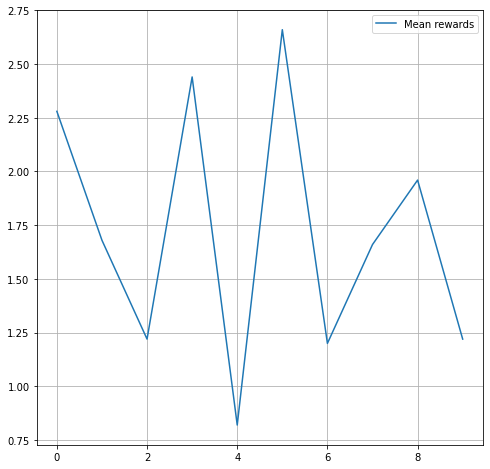

Time spent: 7 minutes 24 seconds


In [105]:
algorithm = SuperGreedyEvaluationManager(make_pong, std=0.005, t_max=10000, n_iters=50)

try:
    for i in range(10):
        t = time.time()
        algorithm.step(model_super_greedy)
        time_spent = time.time() - t
        print(f'Time spent: {int(time_spent // 60)} minutes {int(time_spent) % 60} seconds')
    
except KeyboardInterrupt:
    pass

In [106]:
score(make_pong(), model_super_greedy, n=30, t_max=100000)

0.7333333333333333

In [ ]:
algorithm = SuperGreedyEvaluationManager(make_pong, std=0.005, t_max=10000, n_iters=50)

try:
    for i in range(30):
        t = time.time()
        algorithm.step(model_super_greedy)
        time_spent = time.time() - t
        print(f'Time spent: {int(time_spent // 60)} minutes {int(time_spent) % 60} seconds')
    
except KeyboardInterrupt:
    pass

In [108]:
score(make_pong(), model_super_greedy, n=30, t_max=100000)

KeyboardInterrupt: 